# imports

In [1]:
from noises import *
from phantom import *
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as compare_psnr

# create folders

In [5]:
NOISE_FUNCTIONS.keys()

# make a folder for each key in NOISE_FUNCTIONS
import os
for key in NOISE_FUNCTIONS.keys():
    os.makedirs(f'./{key}', exist_ok=True)

In [7]:
# make directories in the ground truth folder for each resolution
# 64, 128, 256, 512
for res in [64, 128, 256, 512]:
    os.makedirs(f'./ground_truth/{res}', exist_ok=True)


# generate ground truth and sample

In [12]:
# now generate 50 phantoms for each resolution
# save the phantoms to the ground truth folder
for res in [6, 7, 8, 9]:
    for i in range(50):
        # res is 2**res
        # so a 64x64 image has a res of 6
        phantom = generate_phantom(res)
        # save the phantom
        # output is a np array
        np.save(f'./ground_truth/{2**res}/{i}.npy',phantom)

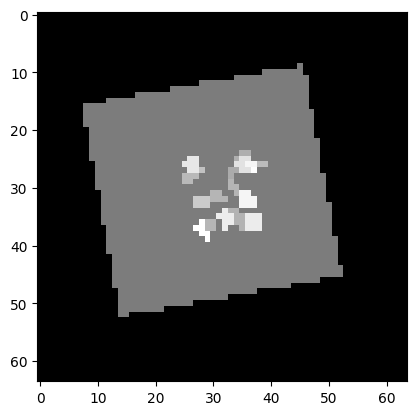

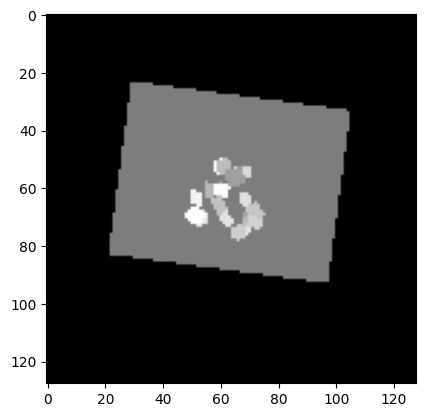

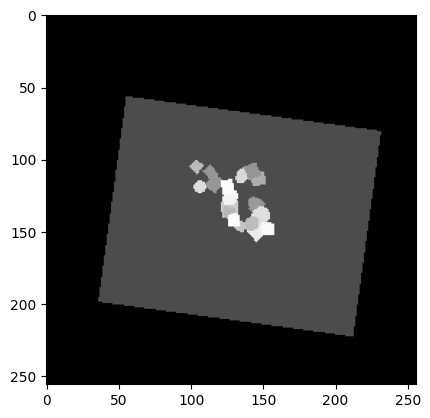

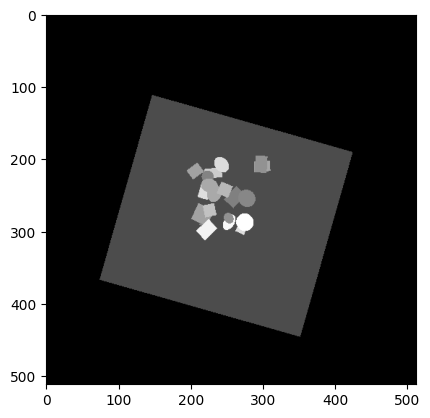

In [19]:
# test plotting one of the phantoms

for res in [6, 7, 8, 9]:
    plt.figure()
    plt.imshow(np.load(f'./ground_truth/{2**res}/0.npy').squeeze(), cmap='gray')

# test noise

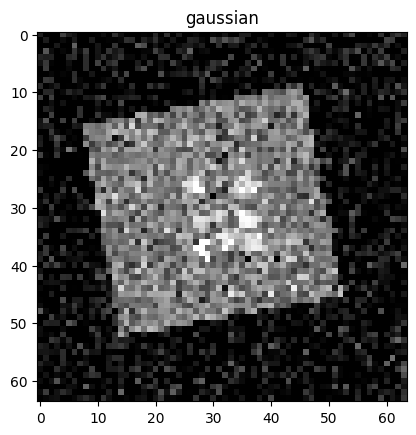

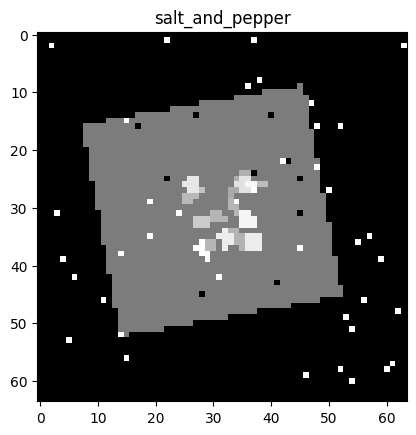

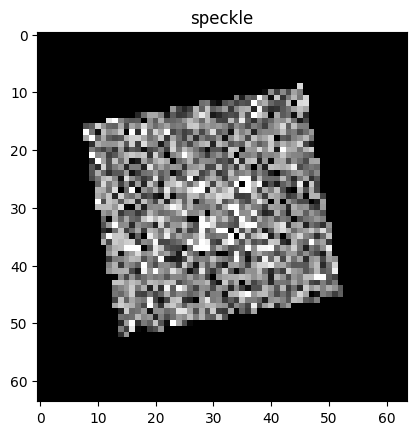

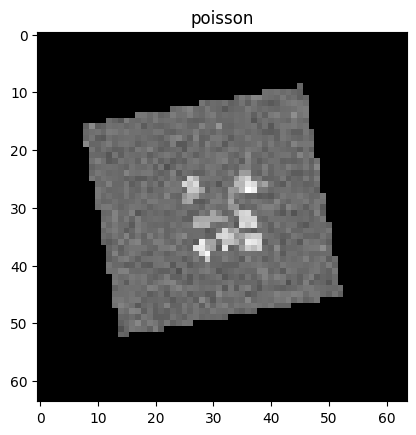

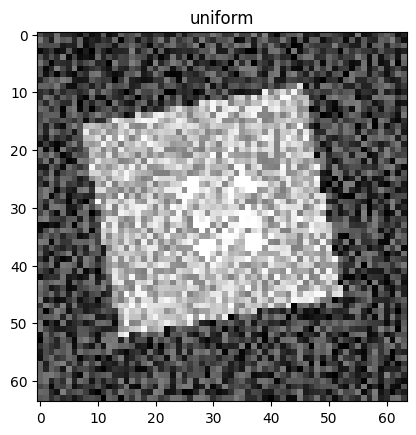

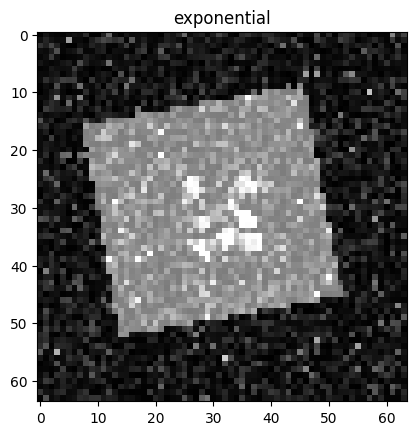

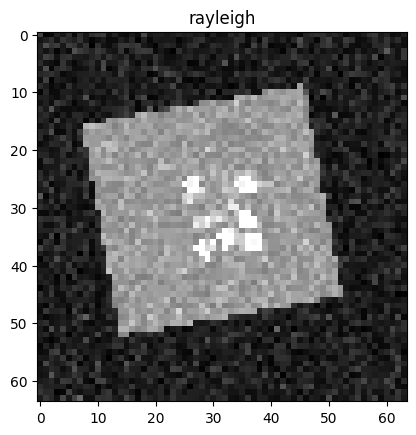

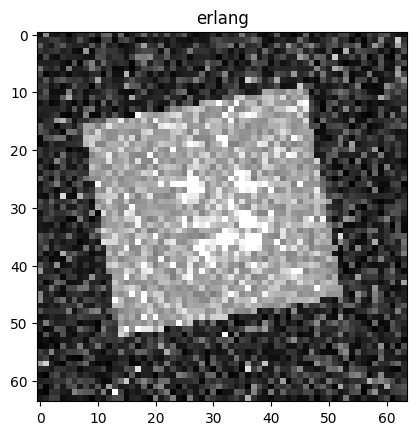

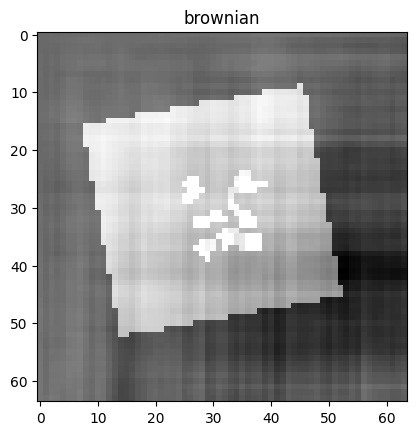

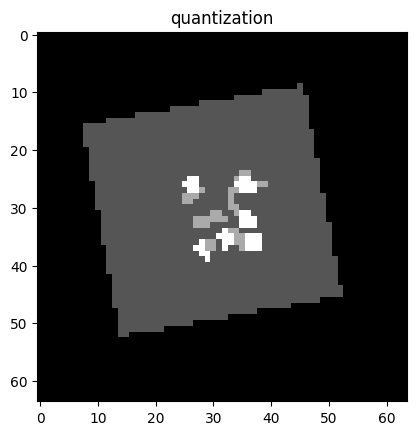

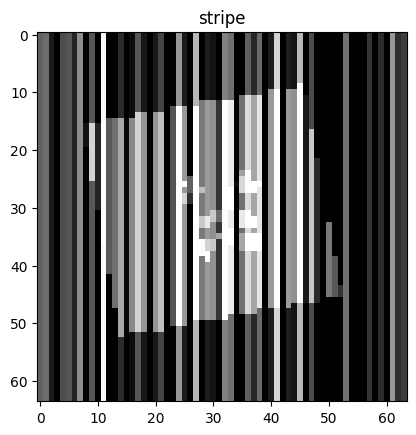

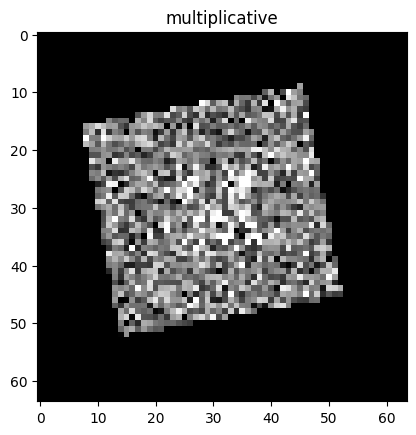

In [2]:
# test applying each noise function to one of the phantoms
# the noise function works like this: add_selected_noise(img, noise_type='gaussian', **kwargs):

img = np.load(f'./ground_truth/64/0.npy').squeeze()
img_torch = phantom_to_torch(img)

for key in NOISE_FUNCTIONS.keys():
    plt.figure()
    noise_img = add_selected_noise(img_torch, noise_type=key)
    # include label of the noise type
    plt.title(key)
    plt.imshow(noise_img.squeeze(), cmap='gray', )

# note all noise is equal

In [14]:
import torch
import torch.nn.functional as F

def psnr(input, target, max_val=1.):
    mse = F.mse_loss(input, target)
    return 20 * torch.log10(max_val / torch.sqrt(mse))

def find_noise_factor_for_psnr(target_psnr, img, noise_function, max_iter=1000, tol=1e-2, **kwargs):
    low, high = 0., 1.
    for i in range(max_iter):
        mid = (low + high) / 2
        noisy_img = noise_function(img, noise_factor=mid, **kwargs)
        current_psnr = psnr(img, noisy_img)
        if (target_psnr - tol) <= current_psnr <= (target_psnr + tol):
            return mid
        if current_psnr < target_psnr:
            high = mid
        else:
            low = mid
    return mid  # return the best approximation after max_iter

# For demonstration
img = np.load(f'./ground_truth/64/0.npy').squeeze()
img_torch = phantom_to_torch(img)

target_psnr_value = 22  # Replace this with your target PSNR value

for key in NOISE_FUNCTIONS.keys():
    # Find noise_factor for Gaussian noise that results in a PSNR of approximately target_psnr_value
    gaussian_noise_factor = find_noise_factor_for_psnr(target_psnr_value, img_torch, add_selected_noise, noise_type=key)

    print(f"Optimal noise factor for {key} noise to achieve PSNR ~ {target_psnr_value}: {gaussian_noise_factor}")


UnboundLocalError: local variable 'noisy_img' referenced before assignment

PSNR: 21.942587919146014


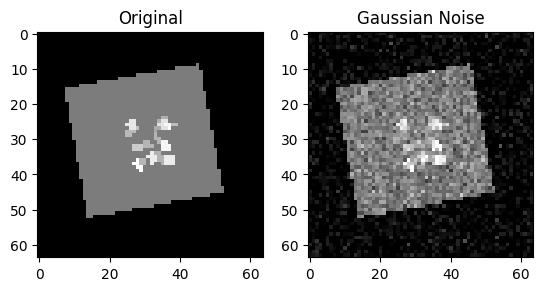

In [12]:

img = np.load(f'./ground_truth/64/0.npy').squeeze()
img_torch = phantom_to_torch(img)

# add gaussian noise to the image
gaussian_noise_img = add_selected_noise(img_torch, noise_type='gaussian', noise_factor=gaussian_noise_factor)

# plot the images side by side
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title('Original')
plt.subplot(1, 2, 2)
plt.imshow(gaussian_noise_img.squeeze(), cmap='gray')
plt.title('Gaussian Noise')

# calculate the psnr
# these need to be numpy arrays
psnr = compare_psnr(img_torch.numpy(), gaussian_noise_img.numpy())
print(f'PSNR: {psnr}')

In [57]:
import torch.nn.functional as F

NOISE_FUNCTIONS = {
    'gaussian': {'function': add_gaussian_noise, 'param': 'noise_factor'},
    'salt_and_pepper': {'function': add_salt_and_pepper_noise, 'param': 'salt_prob'},  # Or 'pepper_prob'
    'speckle': {'function': add_speckle_noise, 'param': 'noise_factor'},
    'poisson': {'function': add_poisson_noise, 'param': None},
    'uniform': {'function': add_uniform_noise, 'param': 'noise_factor'},
    'exponential': {'function': add_exponential_noise, 'param': 'scale'},
    'rayleigh': {'function': add_rayleigh_noise, 'param': 'scale'},
    'erlang': {'function': add_erlang_noise, 'param': 'shape'},  # You can also add 'scale' depending on what you want to vary
    'brownian': {'function': add_brownian_noise, 'param': 'noise_factor'},
    'quantization': {'function': add_quantization_noise, 'param': 'levels'},
    'stripe': {'function': add_stripe_noise, 'param': 'noise_factor'},
    'multiplicative': {'function': add_multiplicative_noise, 'param': 'noise_factor'}
}


def psnr(input, target, max_val=1.):
    mse = F.mse_loss(input, target)
    return 20 * torch.log10(max_val / torch.sqrt(mse))

def find_noise_factor_for_psnr(target_psnr, img, noise_function, param_name, max_iter=1000, tol=1e-2, **kwargs):
    low, high = 0., 1.
    for i in range(max_iter):
        mid = (low + high) / 2
        kwargs[param_name] = mid
        noisy_img = noise_function(img, **kwargs)
        current_psnr = psnr(img, noisy_img)
        if (target_psnr - tol) <= current_psnr <= (target_psnr + tol):
            return mid
        if current_psnr < target_psnr:
            high = mid
        else:
            low = mid
    return mid


img = np.load(f'./ground_truth/64/0.npy').squeeze()
img_torch = phantom_to_torch(img)
target_psnr_value = 22  # Replace with your target PSNR value

for key, val in NOISE_FUNCTIONS.items():
    noise_func = val['function']
    param_name = val['param']
    if param_name:  # Skip noise functions that do not have a parameter to optimize
        optimal_noise_factor = find_noise_factor_for_psnr(target_psnr_value, img_torch, noise_func, param_name)
        # round the values to 5 decimal places
        print(f"Optimal {param_name} for {key} noise to achieve PSNR ~ {target_psnr_value}: {round(optimal_noise_factor, 5)}")




Optimal noise_factor for gaussian noise to achieve PSNR ~ 22: 0.09769
Optimal salt_prob for salt_and_pepper noise to achieve PSNR ~ 22: 0.00764
Optimal noise_factor for speckle noise to achieve PSNR ~ 22: 0.27344
Optimal noise_factor for uniform noise to achieve PSNR ~ 22: 0.1378
Optimal scale for exponential noise to achieve PSNR ~ 22: 0.05664
Optimal scale for rayleigh noise to achieve PSNR ~ 22: 0.056
Optimal shape for erlang noise to achieve PSNR ~ 22: 0.4399
Optimal noise_factor for brownian noise to achieve PSNR ~ 22: 0.19143
Optimal levels for quantization noise to achieve PSNR ~ 22: 0.0
Optimal noise_factor for stripe noise to achieve PSNR ~ 22: 0.09522
Optimal noise_factor for multiplicative noise to achieve PSNR ~ 22: 0.26169


# all but quantization noise looks good

PSNR: 32.703135614495544


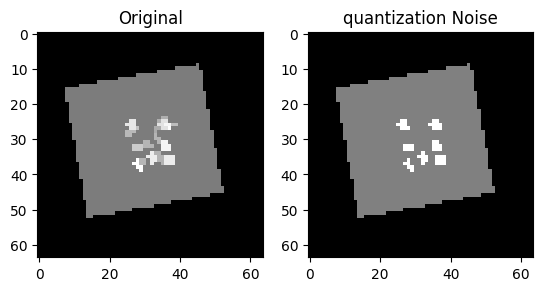

In [50]:

img = np.load(f'./ground_truth/64/0.npy').squeeze()
img_torch = phantom_to_torch(img)

# add gaussian noise to the image
noise_type = 'quantization'
noise_img = add_selected_noise(img_torch, noise_type=noise_type, levels=2.0)

# plot the images side by side
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title('Original')
plt.subplot(1, 2, 2)
plt.imshow(noise_img.squeeze(), cmap='gray')
plt.title(f'{noise_type} Noise')

# calculate the psnr
# these need to be numpy arrays
psnr = compare_psnr(img_torch.numpy(), noise_img.numpy())
print(f'PSNR: {psnr}')

# now apply these noise levels to the ground truth

In [28]:
# these were the values for .095
"""
Optimal noise_factor for gaussian noise to achieve PSNR ~ 22: 0.09472
Optimal salt_prob for salt_and_pepper noise to achieve PSNR ~ 22: 0.00768
Optimal noise_factor for speckle noise to achieve PSNR ~ 22: 0.26771
Optimal noise_factor for uniform noise to achieve PSNR ~ 22: 0.13714
Optimal scale for exponential noise to achieve PSNR ~ 22: 0.05737
Optimal scale for rayleigh noise to achieve PSNR ~ 22: 0.0567
Optimal shape for erlang noise to achieve PSNR ~ 22: 0.43316
Optimal noise_factor for brownian noise to achieve PSNR ~ 22: 0.14934
Optimal levels for quantization noise to achieve PSNR ~ 22: 2.0
Optimal noise_factor for stripe noise to achieve PSNR ~ 22: 0.10187
Optimal noise_factor for multiplicative noise to achieve PSNR ~ 22: 0.2646
"""



array([0.96074583])

In [59]:

import pandas as pd

# Assuming find_noise_factor_for_psnr, NOISE_FUNCTIONS, img_torch, and target_psnr_value are already defined.

num_runs = 1000  # Number of times to run the optimization for each noise type
optimal_factors_table = {}  # Initialize an empty dictionary to store the results

for key, val in NOISE_FUNCTIONS.items():
    noise_func = val['function']
    param_name = val['param']
    if param_name:  # Skip noise functions that do not have a parameter to optimize
        optimal_factors = []
        for i in range(num_runs):
            optimal_factor = find_noise_factor_for_psnr(target_psnr_value, img_torch, noise_func, param_name)
            optimal_factors.append(optimal_factor)

        avg_optimal_factor = np.mean(optimal_factors)
        # Round the values to 5 decimal places
        optimal_factors_table[key] = round(avg_optimal_factor, 5)

# Convert the dictionary to a Pandas DataFrame for better visual representation and ease of exporting
df = pd.DataFrame(list(optimal_factors_table.items()), columns=['Noise_Type', 'Avg_Optimal_Factor'])

# Print the DataFrame to view the results
print(df)

# Optionally, save the DataFrame to a CSV file
df.to_csv('optimal_noise_factors.csv', index=False)

         Noise_Type  Avg_Optimal_Factor
0          gaussian             0.09683
1   salt_and_pepper             0.00754
2           speckle             0.26697
3           uniform             0.13804
4       exponential             0.05647
5          rayleigh             0.05636
6            erlang             0.44335
7          brownian             0.15326
8      quantization             0.00000
9            stripe             0.09790
10   multiplicative             0.26691
